<a href="https://colab.research.google.com/github/keisuke6616/Correlation-tests-for-high-dimensional-data/blob/master/Figure2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import numpy.linalg as la

from scipy.stats import norm
import matplotlib.pyplot as plt 


import time

# Figure 2

In [0]:
t1 = time.time()
np.random.seed(42)

alpha = 0.05
z = norm.isf(q=alpha, loc=0, scale=1)

fnc = function()
N = [20 * i for i in range(1, 7)]
p = 1000
index = [i for i in range(len(N))]

iter = 1000
u = np.zeros(len(N))
omg = np.zeros(len(N))
power = np.zeros((len(N)))
result = np.zeros((len(N), 2))


for n, pc in zip(N, index):
    print('Sample size : {}'.format(n))
    
    Sigma = np.zeros((p, p))
    for i in range(p):
        for j in range(p):
            Sigma[i, j] = 0.3**(np.abs(i - j)**(1 / 3))
    value, vec = fnc.eig_sort(Sigma)
    Gamma = np.sqrt(value).reshape(-1, p) * vec
    
    c_1 = [0 for i in range(p)] + [1]
    c_2 = [0 for i in range(p)] + [np.sqrt(1 / 2)]
    c_2[4] = np.sqrt(1 / 2)
    c = [c_1, c_2]
    
    trS = np.trace(np.dot(Sigma, Sigma))
    sigma = c[1][4] * Gamma.T[4]
    u[pc] = 2 * n * (np.einsum('i, ij, j', sigma, Sigma, sigma) + la.norm(sigma)**4) / trS
    point = n * la.norm(sigma)**2 / (np.sqrt(2 * trS * (1 + u[pc]))) - z / np.sqrt(1 + u[pc])
    power[pc] = norm.cdf(x=point, loc=0, scale=1)
    
    for k in range(2):
        for l in range(iter):
            W = np.random.normal(0, 1, (n, p))
            X = np.dot(W, Gamma.T)
         
            w = np.random.normal(0, 1, n)
            x = np.zeros(n)

            
            for j in range(n):
                x[j] = np.sum(c[k][i] * W[j, i] for i in range(p)) + c[k][p] * w[j]
            S = np.var(x, ddof=1)

            crit = fnc.T_hat(X, x) / (S * np.sqrt(2 * fnc.ECDM_data(X)) / n)
            if k == 0:
                if crit > z:
                    result[pc, 0] += 1
            elif k == 1:
                if crit <= z:
                    result[pc, 1] += 1
            

    print('Size : {}'.format(result[pc, 0] / iter))
    print('Power : {}'.format(1 - result[pc, 1] / iter))
    print('')
    
    
t2 = time.time()
print('')
print('Calculation time : {}'.format(t2 - t1))

Sample size : 20
Size : 0.063
Power : 0.28500000000000003

Sample size : 40
Size : 0.058
Power : 0.591

Sample size : 60
Size : 0.054
Power : 0.841

Sample size : 80
Size : 0.072
Power : 0.959

Sample size : 100
Size : 0.056
Power : 0.995

Sample size : 120
Size : 0.055
Power : 0.999


Calculation time : 2331.4239830970764


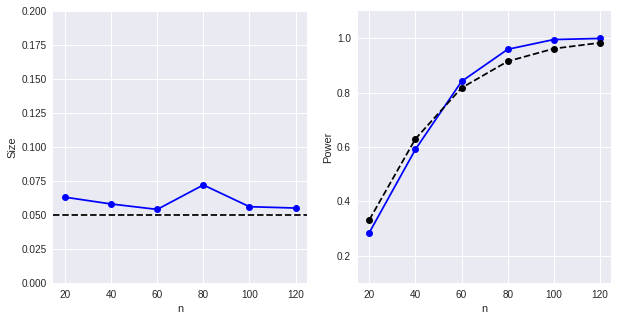

In [0]:
Size = result.T[0] / iter
Power =1 - result.T[1] / iter

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(N, Size, 'o-', color='blue')
plt.axhline(y=alpha, color='black', linestyle='dashed')
plt.ylim(0, 0.2)
plt.ylabel('Size')
plt.xlabel('n')


plt.subplot(1, 2, 2)
plt.plot(N, Power, 'o-', color='blue')
plt.plot(N, power, 'o--', color='black')
plt.ylim(0.1, 1.1)
plt.ylabel('Power')
plt.xlabel('n')

plt.show()

# Function

In [0]:
import numpy as np
import numpy.linalg as la
from scipy.stats import norm

class function:
    
    
################################ prepare ########################################################
    
            
    def eig_sort(self, S):
        value, vec = la.eig(S)
        idx = value.argsort()[::-1]
        P = value[idx]
        Q = vec.T[idx]

        return (P, Q.T)
    
    
    
    def  svd_sort(self, S):
        vec_r, value, vec_l = la.svd(S)
        idx = value.argsort()[::-1]
        P = value[idx]
        Q_r = vec_r.T[idx]
        Q_l = vec_l.T[idx]
        
        return (Q_r.T, P, Q_l.T)
 


    def data(self, X, bias=False):
        self.bias = bias
        self.N, self.D = X.shape
        self.X = X
        if bias == False:
            self.mean = np.array([np.mean(self.X, axis=0)]*self.N)
            self.S = np.dot(self.X - self.mean, (self.X - self.mean).T) / (self.N - 1)
            self.value, self.vec = self.eig_sort(self.S)
        
        elif bias == True:
            self.S = np.dot(self.X, self.X.T) / self.N
            self.value, self.vec = self.eig_sort(self.S)
    
    
    
    def sign_ad(self, Z): 
        X = Z.T[:self.N+1]
        Y = self.vec.T[:self.N+1]
        for i in range(self.N):
            sign = np.dot(X[i], Y[i])
            if sign < 0:
                Y[i] = - Y[i]

        return Y.T
    
    
    
    def P(self):
        one = np.array([1 for i in range(self.N)])
        mat = np.eye(self.N) - np.einsum('i, j -> ij', one, one) / self.N
        return mat
    
    
    
###################### check SSE Model ###############################
   
    def check_sse(self):
        value = self.CDM_value()
        SDcross = self.SDcross
        phi, tau = [0]*self.n2, [0]*self.n2
        
        def kappa(n):
            return np.sqrt((n**(-1) * np.log(n)))
    
        for j in range(self.n2):
            phi[j] = np.trace(np.dot(SDcross, SDcross.T)) - np.sum(value[i]**2 for i in range(j))
        
        for j in range(self.n2 - 1):
            tau[j] = phi[j + 1] / phi[j]
            if tau[j] * (1 + (j + 1) * kappa(self.N)) > 1:
                mhat = j - 1
                break
                
        mhat = np.min([mhat, self.n2 - 3])
        
        return mhat
    
    
    
######################## estimation of eigen vector ########################
    
    def et_vec(self, value, M):
        
        vec = np.zeros((self.D, M))    
        value = value[:M+1]
        
        if self.bias == False:
            for m in range(M):
                vec.T[m] = np.dot(self.vec.T[m], self.X - self.mean) / np.sqrt((self.N - 1) * value[m])
                
        if self.bias == True:
            for m in range(M):
                vec.T[m] = np.dot(self.vec.T[m], self.X) / np.sqrt(self.N * value[m])
                
        return vec  
    
    
    
    
################################ projection matrix #########################################

    def prj(self, vec, M):
        prj = np.eye(self.D) - np.sum(np.einsum('i, j -> ij', vec.T[i], vec.T[i]) for i in range(M))
        return prj


    
######################################### dual covariance matrix #######################################
    def dual(self):
        return (self.value, self.vec)
    
    def dual_value(self):
        return self.value
    
    
    
########################################### noise-reduction ##############################################
    
    def NRM_value(self): 
        value = np.zeros(self.N)
        
        if self.bias == False:
            for j in range(self.N - 2):
                value[j] = self.value[j] - (np.trace(self.S) - np.sum(self.value[0 :(j+1)])) / (self.N - j - 2)
        
        elif self.bias == True:
            for j in range(self.N - 1):
                value[j] = self.value[j] - (np.trace(self.S) - np.sum(self.value[0 :(j+1)])) / (self.N - j - 1)
            
        return value
    
    
    
    def NRM(self): 
        M = self.check_sse()
        value = self.NRM_value()
        
        spiked_vec = et_vec(velue, M)
        prj = self.prj(spiked_vec, M)
        
        return (value, spiked_vec, prj, M)
    
    
   
               
        
####################################### cross-data-methodology #############################################
        
    
    def CDM_value(self):
        value = np.zeros(self.N)

        n1 = int(np.ceil(self.N / 2))
        n2 = self.N - n1
        self.n2 = n2
        X1, X2 = self.X[:n1], self.X[-n2:]
        
        if self.bias == False:    
            mean1 = np.array([np.mean(X1, axis=0)] * n1)
            mean2 = np.array([np.mean(X2, axis=0)] * n2)
            
            self.SDcross = np.dot(X1 - mean1, (X2 - mean2).T) / np.sqrt((n1 - 1) * (n2 - 1))
            value = self.svd_sort(self.SDcross)[1]
            
        if self.bias == True:
            self.SDcross = np.dot(X2, X1.T) / np.sqrt(n1 * n2)
            value = self.svd_sort(self.SDcross)[1]
            
        return value
    
    
    
    
    def CDM(self):
        M = self.check_sse()
        value = self.CDM_value()
        
        spiked_vec = et_vec(value, M)
        prj = self.prj(spiked_vec, M)
        
        return (value, spiked_vec, prj, M)
    
    
    

############################### estiomation of tr(Sigma^2) #################################
    
        
    def ECDM_data(self, X):
        N, D = X.shape
        n = []
        n.append(int(np.ceil(N / 2)))
        n.append(N - n[0])

        K = [i for i in range(3, 2*N)]
        index =  [i for i in range(len(K))]


        V = [[], []]
        Y = np.zeros((2, len(K), D))
        for k, pc in zip(K, index):
            dv = int(np.floor(k / 2))

            if dv < n[0]:
                V[0].append([i for i in range(dv)] + [i for i in range(dv + n[1], N)])  
            else:
                V[0].append([i for i in range(dv - n[0], dv)])

            if dv <= n[0]:
                V[1].append([i for i in range(dv, dv + n[1])])
            else:
                V[1].append([i for i in range(dv - n[0])] + [i for i in range(dv, N)])

            for i in range(2):
                Y[i, pc] = np.sum(X[V[i][pc]], axis=0) / n[i]

        w = 0
        for j in range(N):
            for i in range(j):
                w += np.dot(X[i] - Y[0][i + j - 1], X[j] - Y[1][i + j - 1]) ** 2

        u =  n[0] * n[1] / ((n[0] - 1) * (n[1] - 1))
        W = 2 * u / (N * (N - 1)) * w

        return W
    
    
    
    def ECDM(self):
        n = []
        n.append(int(np.ceil(self.N / 2)))
        n.append(self.N - n[0])

        K = [i for i in range(3, 2*self.N)]
        index =  [i for i in range(len(K))]


        V = [[], []]
        Y = np.zeros((2, len(K), self.D))
        for k, pc in zip(K, index):
            dv = int(np.floor(k / 2))

            if dv < n[0]:
                V[0].append([i for i in range(dv)] + [i for i in range(dv + n[1], self.N)])  
            else:
                V[0].append([i for i in range(dv - n[0], dv)])

            if dv <= n[0]:
                V[1].append([i for i in range(dv, dv + n[1])])
            else:
                V[1].append([i for i in range(dv - n[0])] + [i for i in range(dv, self.N)])

            for i in range(2):
                Y[i, pc] = np.sum(self.X[V[i][pc]], axis=0) / n[i]

        w = 0
        for j in range(self.N):
            for i in range(j):
                w += np.dot(self.X[i] - Y[0][i + j - 1], self.X[j] - Y[1][i + j - 1]) ** 2

        u =  n[0] * n[1] / ((n[0] - 1) * (n[1] - 1))
        W = 2 * u / (self.N * (self.N - 1)) * w

        return W
    
    
    
############### T_hat #####################################3

    def T_hat(self, X, x):
        N, p = X.shape

        n = []
        n.append(int(np.ceil(N / 2)))
        n.append(N - n[0])

        K = [i for i in range(3, 2*N)]
        index =  [i for i in range(len(K))]


        V = [[], []]
        Y = np.zeros((2, len(K), p))
        y = np.zeros((2, len(K)))
        for k, pc in zip(K, index):
            dv = int(np.floor(k / 2))

            if dv < n[0]:
                V[0].append([i for i in range(dv)] + [i for i in range(dv + n[1], N)])   
            else:
                V[0].append([i for i in range(dv - n[0], dv)])

            if dv <= n[0]:
                V[1].append([i for i in range(dv, dv + n[1])])
            else:
                V[1].append([i for i in range(dv - n[0])] + [i for i in range(dv, N)])

            for i in range(2):
                Y[i, pc] = np.sum(X[V[i][pc]], axis=0) / n[i]
                y[i, pc] = np.sum(x[V[i][pc]]) / n[i]

        w = 0
        for j in range(N):
            for i in range(j):
                w += np.dot(X[i] - Y[0][i + j - 1], X[j] - Y[1][i + j - 1]) * (x[i] - y[0][i + j - 1]) * (x[j] - y[1][i + j - 1])

        u =  n[0] * n[1] / ((n[0] - 1) * (n[1] - 1))
        T = 2 * u / (N * (N - 1)) * w

        return T

## Create ${\hat{T}_{n, \sigma}}$

In [0]:
def T_hat(X, x):
    N, p = X.shape
    
    n = []
    n.append(int(np.ceil(N / 2)))
    n.append(N - n[0])
    
    K = [i for i in range(3, 2*N)]
    index =  [i for i in range(len(K))]

    
    V = [[], []]
    Y = np.zeros((2, len(K), p))
    y = np.zeros((2, len(K)))
    for k, pc in zip(K, index):
        dv = int(np.floor(k / 2))

        if dv < n[0]:
            V[0].append([i for i in range(dv)] + [i for i in range(dv + n[1], N)])   
        else:
            V[0].append([i for i in range(dv - n[0], dv)])

        if dv <= n[0]:
            V[1].append([i for i in range(dv, dv + n[1])])
        else:
            V[1].append([i for i in range(dv - n[0])] + [i for i in range(dv, N)])
           
        for i in range(2):
            Y[i, pc] = np.sum(X[V[i][pc]], axis=0) / n[i]
            y[i, pc] = np.sum(x[V[i][pc]]) / n[i]
            
    w = 0
    for j in range(N):
        for i in range(j):
            w += np.dot(X[i] - Y[0][i + j - 1], X[j] - Y[1][i + j - 1]) * (x[i] - y[0][i + j - 1]) * (x[j] - y[1][i + j - 1])

    u =  n[0] * n[1] / ((n[0] - 1) * (n[1] - 1))
    T = 2 * u / (N * (N - 1)) * w
    
    return T

## ECDM

In [0]:
import numpy as np

def ECDM(X):
    N, p = X.shape
    
    n = []
    n.append(int(np.ceil(N / 2)))
    n.append(N - n[0])
    
    K = [i for i in range(3, 2*N)]
    index =  [i for i in range(len(K))]

    
    V = [[], []]
    Y = np.zeros((2, len(K), p))
    for k, pc in zip(K, index):
        dv = int(np.floor(k / 2))

        if dv < n[0]:
            V[0].append([i for i in range(dv)] + [i for i in range(dv + n[1], N)])   
        else:
            V[0].append([i for i in range(dv - n[0], dv)])

        if dv <= n[0]:
            V[1].append([i for i in range(dv, dv + n[1])])
        else:
            V[1].append([i for i in range(dv - n[0])] + [i for i in range(dv, N)])
           
        for i in range(2):
            Y[i, pc] = np.sum(X[V[i][pc]], axis=0) / n[i]
            
    w = 0
    for j in range(N):
        for i in range(j):
            w += np.dot(X[i] - Y[0][i + j - 1], X[j] - Y[1][i + j - 1]) ** 2

    u =  n[0] * n[1] / ((n[0] - 1) * (n[1] - 1))
    W = 2 * u / (N * (N - 1)) * w

    return W

## SortEig

In [0]:
import numpy as np
import numpy.linalg as la

def SortEig(X):
    value, vec = la.eig(X)
    idx = value.argsort()[::-1]
    P = value[idx]
    Q = vec.T[idx]
       
    return(P, Q.T)